In [5]:
import numpy as np
import scipy.stats as stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython import display

sns.set()

Зафиксируем параметры модели:
- $\lambda$ - интенсивность процесса Пуассона, в соответствии с которым возникают страховые случаи;
- $c$ - скорость поступления выплат;
- $x$ - начальный капитал компании;
- для простоты в качестве размера выплат по страховым случаям $\eta_i$ возьмем равномерное распределение на отрезке $[m, M]$: $\eta_i \sim U[m, M]$, соответственно $m, M$ - параметры этого распределения;
- $b, a$ - параметры линейной барьерной функции, по которой определяется размер выплаты дивидендов.

In [6]:
tol = 1e-9

pois_lambda = 2
c_income = 25
x_start = 20
min_case = 2
max_case = 12
b_div_start = 25
a_div_coef = 12

В таком случае функция $\psi(r)$ (из анализа стандартной модели Крамера-Лундберга) примет вид:

$$
\begin{align}
\psi(r) = \mathbb(E) e^{r eta_1} = \displaystyle \int_m^M \frac{e^{rx}}{M - m} dx = \frac{e^{rM} - e^{rm}}{r(M - m)}.
\end{align}
$$

Подставим её в функцию $g(r)$

$$
\begin{align}
g(r) = \lambda (\psi(r) - 1) - rc = \lambda \Big( \frac{e^{rM} - e^{rm}}{r(M - m)} - 1 \Big) - rc.
\end{align}
$$

Для подсчета вероятности разорения необходимо найти единственный положительный корень уравнения $g(r) = 0$. При этом мы доказывали, что корень уравнения единственен в предположении, что $c - \lambda \mathbb{E} \eta_1 > 0$.

In [7]:
def g(r, lam, m, M, c):
    return lam * (np.e ** (r * M) - np.e ** (r * m)) \
                / r / (M - m) - lam - r * c

In [8]:
def calc_R(lam, m, M, c):
    assert c - lam * (m + M) / 2 > 0
    r_bnds = ((tol, None),)
    g_lambda = lambda r: np.abs(g(r[0], lam, m, M, c))
    return minimize(g_lambda, (10,), method='Powell', bounds=r_bnds, tol=tol)


R_res = calc_R(pois_lambda, min_case, max_case, c_income)
R_res

   direc: array([[4.41105791e-07]])
     fun: 8.881784197001252e-16
 message: 'Optimization terminated successfully.'
    nfev: 191
     nit: 3
  status: 0
 success: True
       x: array([0.12554242])

Убедимся, что полученный корень подходит, построив график функции $g(r)$:

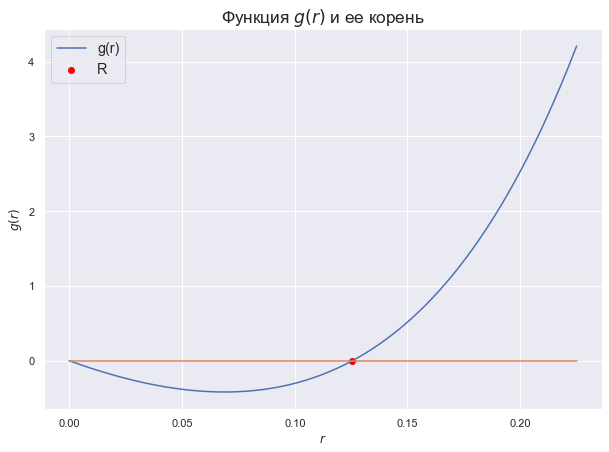

In [9]:
R = R_res.x[0]

rs = np.arange(tol, R + 0.1, 0.001)
gs = [g(r, pois_lambda, min_case, max_case, c_income) for r in rs]

plt.figure(figsize=(10,7))
plt.title(r'Функция $g(r)$ и ее корень', {'fontsize' : 'x-large'})
plt.plot(rs, gs, label='g(r)')
plt.plot(rs, [0 for r in rs])
plt.scatter([R], [g(R, pois_lambda, min_case, max_case, c_income)], label='R', c='red')
plt.xlabel(r'$r$')
plt.ylabel(r'$g(r)$')
plt.legend(fontsize='large')
plt.show()

Теперь нам нужно найти корень еще одного характеристического уравнения, принимающего вид:

$$
\begin{align}
\mathbb{E} e^{-q \eta_1} = \frac{\lambda + Ra + q(a - c)}{\lambda} \\
\frac{e^{-qm} - e^{-qM}}{q(M - m)} = \frac{\lambda + Ra + q(a - c)}{\lambda}.
\end{align}
$$

При этом мы знаем, что единственный корень $Q$ этого уравнения удавлетворяет неравенству:

$$
\begin{align}
\frac{Ra}{c - a} < Q < \frac{Ra + \lambda}{c - a}.
\end{align}
$$

In [10]:
def left_f(q, m, M):
    return (np.e ** (-q * m) - np.e ** (-q * M)) / q / (M - m)

def right_f(q, R, lam, a, c):
    return (lam + R * a + q * (a - c)) / lam

In [11]:
def calc_Q(R, lam, m, M, a, c):
    minimize_f = lambda q: np.abs(left_f(q[0], m, M) - right_f(q[0], R, lam, a, c))
    left_q_bound = R * a / (c - a)
    right_q_bound = (R * a + lam) / (c - a)
    q_bnds = ((left_q_bound, right_q_bound),)
    return minimize(minimize_f, ((left_q_bound + right_q_bound) / 2,), method='Powell', bounds=q_bnds, tol=tol)


Q_res = calc_Q(R, pois_lambda, min_case, max_case, a_div_coef, c_income)

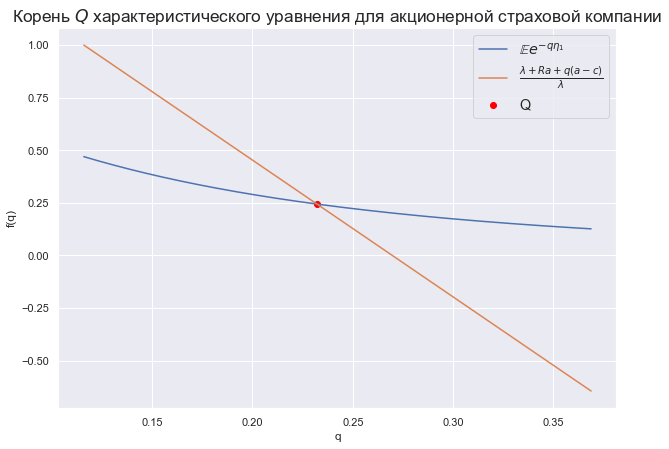

In [12]:
Q = Q_res.x[0]

left_q_bound = R * a_div_coef / (c_income - a_div_coef)
right_q_bound = (R * a_div_coef + pois_lambda) / (c_income - a_div_coef)
qs = np.arange(left_q_bound, right_q_bound + 0.1, 0.001)
left_fs = [left_f(q, min_case, max_case) for q in qs]
right_fs = [right_f(q, R, pois_lambda, a_div_coef, c_income) for q in qs]

plt.figure(figsize=(10,7))
plt.title(r'Корень $Q$ характеристического уравнения для акционерной страховой компании', {'fontsize' : 'x-large'})
plt.plot(qs, left_fs, label=r'$\mathbb{E} e^{-q \eta_1}$')
plt.plot(qs, right_fs, label=r'$\frac{\lambda + Ra + q(a - c)}{\lambda}$')
plt.scatter([Q], [left_f(Q, min_case, max_case)], label='Q', c='red')
plt.xlabel('q')
plt.ylabel('f(q)')
plt.legend(fontsize='large')
plt.show()

Теперь по полученной из теоретических выкладок формуле можем вычислить оценку вероятности разорения компании в заданных параметрах:

$$
\begin{align}
\psi^{div}(x, b) \leq e^{-Rx} + \frac{2R \cdot e^{-(R + Q) b + Qx}}{Q}.
\end{align}
$$

In [21]:
def est_ruin_default_prob(R, x):
    return np.e ** (-R * x)

def est_ruin_div_prob(R, Q, x, b):
    x_init = min(x, b)
    K = 2 * R / Q
    return est_ruin_default_prob(R, x_init) + K * np.e ** (-(R + Q) * b + Q * x_init)

def calc_est_ruin_prob(R, Q, x, b):
    return est_ruin_default_prob(R, x), est_ruin_div_prob(R, Q, x, b)
    
    
def calc_estimation(x, lam, c, m, M, b, a):
    R = calc_R(lam, m, M, c).x[0]
    Q = calc_Q(R, lam, m, M, a, c).x[0]
    return calc_est_ruin_prob(R, Q, x, b)

In [25]:
cur_est_ruin_default_prob, cur_est_ruin_div_prob = calc_estimation(
    x_start,
    pois_lambda,
    c_income,
    min_case,
    max_case,
    b_div_start,
    a_div_coef
)

print('Верхняя оценка вероятности разорения в стандартной модели Крамера-Лундберга: < {:.5f}.'.format(cur_est_ruin_default_prob))
print('Верхняя оценка вероятности разорения акционерной страховой компании: < {:.5f}.'.format(cur_est_ruin_div_prob))

Верхняя оценка вероятности разорения в стандартной модели Крамера-Лундберга: < 0.08120.
Верхняя оценка вероятности разорения акционерной страховой компании: < 0.09588.


Теперь, когда мы научились вычислять теоретические оценки вероятностей разорения, рассмотрим их зависимость от различных параметров модели.

In [29]:
default_params = {
    'pois_lambda': 2,
    'c_income': 25,
    'x_start' : 20,
    'min_case' : 2,
    'max_case' : 12,
    'b_div_start' : 25,
    'a_div_coef' : 12,
}

param_ranges = {
    'pois_lambda': np.arange(0.01, 5, 0.01),
    'c_income': np.arange(1, 100, 0.05),
    'x_start' : np.arange(0, 100, 0.05),
    'min_case' : np.arange(0.5, 11.9, 0.01),
    'max_case' : np.arange(2.1, 25, 0.01),
    'b_div_start' : np.arange(0, 100, 0.05),
    'a_div_coef' : np.arange(1, 100, 0.05),
}

params_pretty = {
    'pois_lambda': r'$\lambda$',
    'c_income': r'$c$',
    'x_start' : r'$x$',
    'min_case' : r'$m$',
    'max_case' : r'$M$',
    'b_div_start' : r'$b$',
    'a_div_coef' : r'$a$',
}

conds = [
    lambda params: params['c_income'] - params['pois_lambda'] * (params['min_case'] + params['max_case']) / 2 > 0,
    lambda params: params['c_income'] > params['a_div_coef']
]

In [33]:
def plot_prob_to_param_relation(param_name, param_range, default_param_value, stock_relation_history, default_relation_history):
    plt.plot(param_range, stock_relation_history, label='Верхняя оценка вероятности разорения в модели с выплатой дивидендов')
    plt.plot(param_range, default_relation_history, label='Верхняя оценка вероятности разорения в стандартной модели')
    plt.vlines(default_param_value, np.min(default_relation_history), np.max(stock_relation_history), label='Рассматриваемое значение параметра', linestyles='dashed', color='red')
    plt.xlabel(param_name)
    plt.ylabel(r'$\psi^{div}($' + param_name + r'$)$')
    plt.legend()

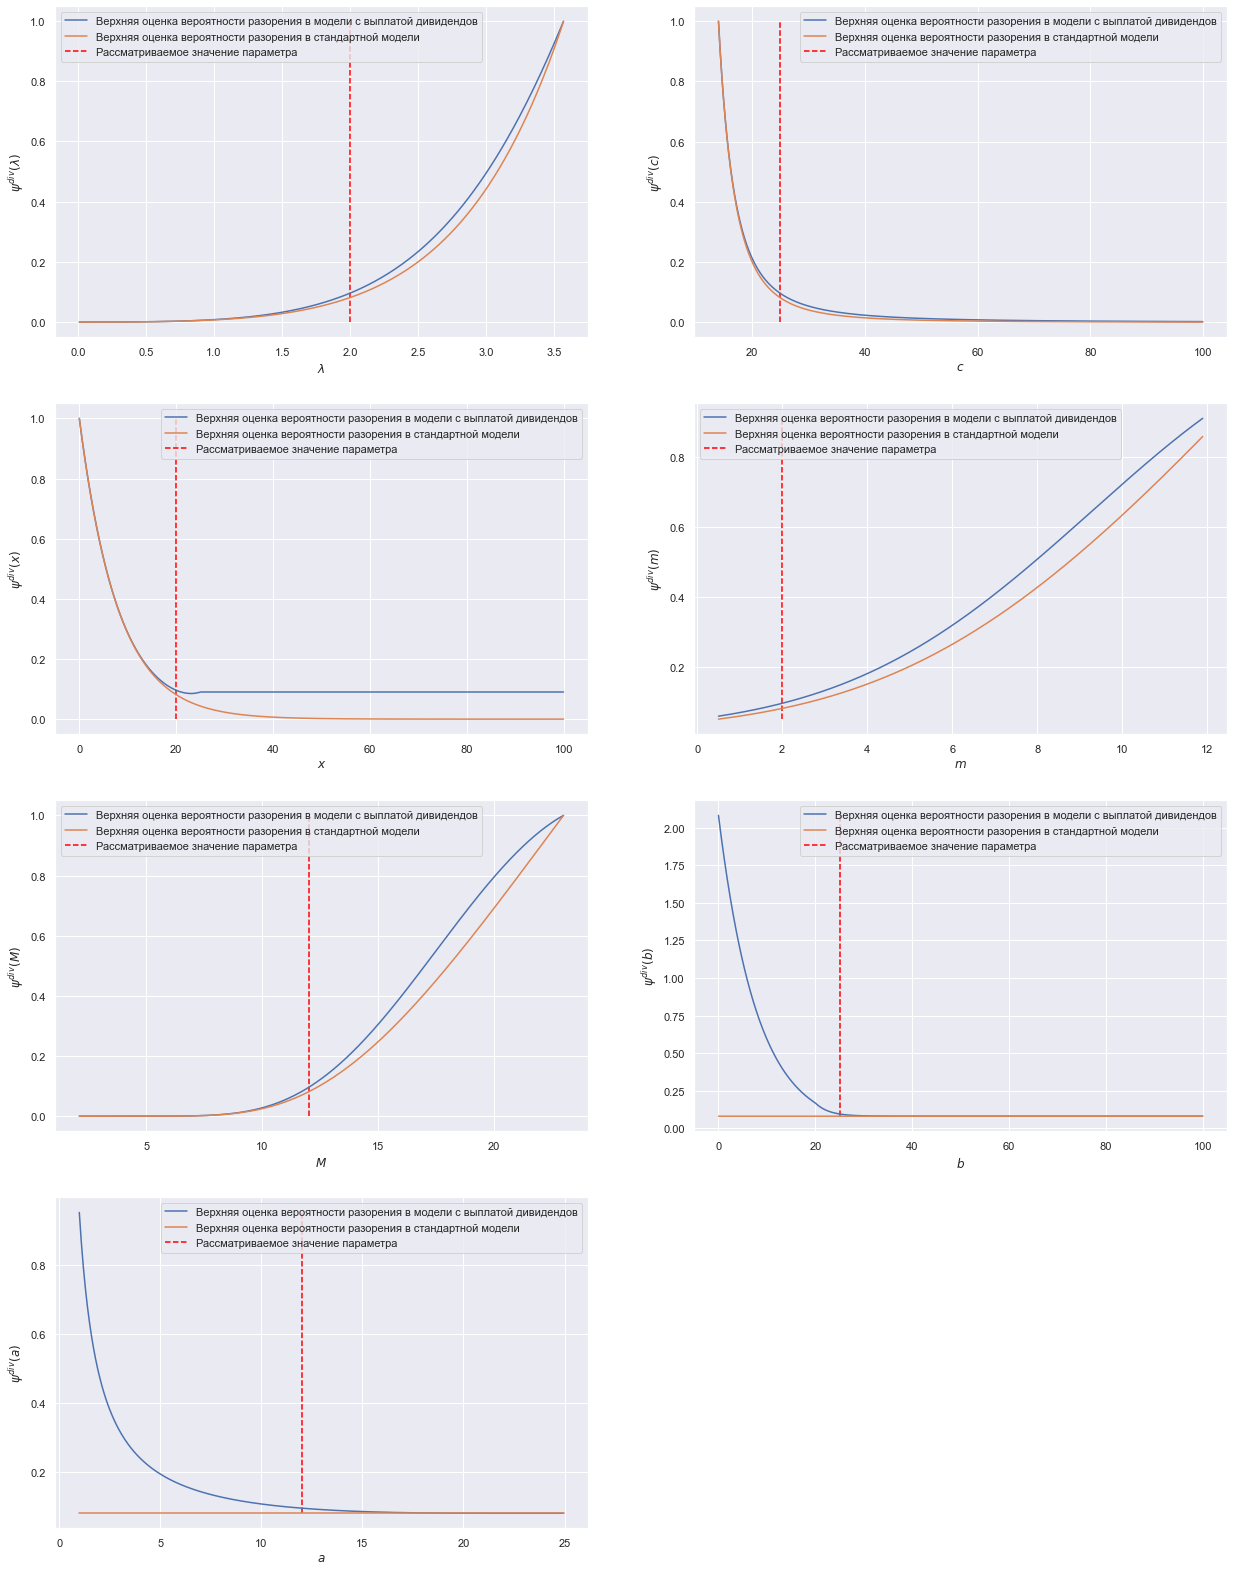

In [34]:
rows = 4
columns = 2
plt.figure(figsize=(21,28))

i = 1
for param_name, param_range in param_ranges.items():
    cur_params = default_params.copy()
    stock_relation_history = []
    default_relation_history = []
    plot_param_range = []
    for param_value in param_range:
        cur_params[param_name] = param_value
        satisfied = True
        for cond in conds:
            if not cond(cur_params):
                satisfied = False
                break
                
        if not satisfied:
            continue
            
        plot_param_range.append(param_value)
        ruin_default_prob, ruin_stock_prob = calc_estimation(
            cur_params['x_start'],
            cur_params['pois_lambda'],
            cur_params['c_income'],
            cur_params['min_case'],
            cur_params['max_case'],
            cur_params['b_div_start'],
            cur_params['a_div_coef']
        )
        stock_relation_history.append(ruin_stock_prob)
        default_relation_history.append(ruin_default_prob)
        
    plt.subplot(rows, columns, i)
    plot_prob_to_param_relation(params_pretty[param_name], plot_param_range, default_params[param_name], stock_relation_history, default_relation_history)
    i += 1

plt.show()

Видно, что при наших текущих параметрах отличия между стандартной моделью и моделью с выплатой дивидендов несущественны. Будем держать это в уме, когда приступим к нахождению эмпирической оценки вероятности разорения.

Теперь перейдем непосредственно к моделированию случайного процесса капитала акционерной страховой компании.

Зададим интерфейс для получения значения барьерной функции в заданный момент времени:

In [39]:
class Barrier:
    def get_value_at(self, t):
        pass

Сразу же реализуем линейную барьерную функцию:

In [40]:
class LinearBarrier(Barrier):
    def __init__(self, b, a):
        self.b = b
        self.a = a
        
    def get_value_at(self, t):
        return self.b + self.a * t

Зададим также интерфейс для произвольной модели страховой компании:

In [41]:
class InsuranceModel:
    def get_next_insurance_case_time(self):
        pass
    
    def get_insurance_case_payout(self):
        pass
    
    def update(self, t, payout):
        pass
    
    def get_capital(self):
        pass

Реализуем интерфейс для описанной модели акционерной страховой компании:

In [42]:
class KLStockInsuranceModel(InsuranceModel):
    PREGENERATE_NUMBER = 100
    
    def __init__(self, start_capital, income, lambda_rate, payouts_distr, barrier):
        self.barrier = barrier
        self.income = income
        self.exp_distr = stats.expon(scale=1 / lambda_rate)
        self.payouts_distr = payouts_distr
        self.start_capital = start_capital
        self.capital = min(self.start_capital, self.barrier.get_value_at(0))
        self.t = 0
        self.__pregenerate(self.PREGENERATE_NUMBER)
        
    def __pregenerate(self, n):
        self.payouts_shifts = self.exp_distr.rvs(size=n)
        self.payouts = self.payouts_distr.rvs(size=n)
        self.cur_payout = 0
        
    def get_next_insurance_case_time(self):
        return self.t + self.payouts_shifts[self.cur_payout]
    
    def get_insurance_case_payout(self):
        return self.payouts[self.cur_payout]
    
    def update(self, t, payout):
        assert t == self.get_next_insurance_case_time() and payout == self.payouts[self.cur_payout]
        expected_capital = min(self.capital + self.income * (t - self.t), self.barrier.get_value_at(t))
        self.capital = expected_capital - payout
        self.t = t
        self.cur_payout += 1
        if self.cur_payout == len(self.payouts):
            self.__pregenerate(self.PREGENERATE_NUMBER)
    
    def get_capital(self):
        return self.capital
    
    def reset(self):
        self.capital = min(self.start_capital, self.barrier.get_value_at(0))
        self.t = 0
        self.__pregenerate(self.PREGENERATE_NUMBER)

In [43]:
def run_model(model, barrier, max_time):
    t_history = [0]
    capital_history = [model.get_capital()]
    payouts_history = []

    while t_history[-1] < max_time and capital_history[-1] >= 0:
        next_t = model.get_next_insurance_case_time()
        next_payout = model.get_insurance_case_payout()
        model.update(next_t, next_payout)
        t_history.append(next_t)
        capital_history.append(model.get_capital())
        payouts_history.append(next_payout)

    real_ts = []
    real_capital_history = []
    ts = np.arange(t_history[0], t_history[-1], 0.01)
    last_payout = 0
    for t in ts: 
        if t >= t_history[last_payout + 1]:
            last_payout += 1
            real_ts.append(t)
            real_capital_history.append(np.nan)

        real_ts.append(t)
        real_capital_history.append(min(
            capital_history[last_payout] + c_income * (t - t_history[last_payout]),
            barrier.get_value_at(t)
        ))
        
    capital_history_before_payouts = np.array(capital_history[1:]) + np.array(payouts_history)
    return (real_ts, real_capital_history), (t_history[1:], capital_history[1:], capital_history_before_payouts)

In [44]:
barrier = LinearBarrier(b_div_start, a_div_coef)
model = KLStockInsuranceModel(
    x_start,
    c_income,
    pois_lambda,
    stats.uniform(loc=min_case, scale=(max_case - min_case)),
    barrier
)

In [45]:
def plot_insurance_history(real_history, payouts_bars_history, barrier_history):
    plt.plot(real_history[0], real_history[1], label='Траектория капитала', c='green')
    plt.vlines(payouts_bars_history[0], payouts_bars_history[1], payouts_bars_history[2], label='Выплаты по страховым случаям', color='red')
    plt.plot(real_history[0], barrier_history, label='Барьерная функция', ls='--')
    plt.xlabel('t')
    plt.ylabel(r'$U_t$')
    plt.legend(fontsize='large')

Запустим моделирование и изобразим полученные траектории капитала страховой компании на графиках:

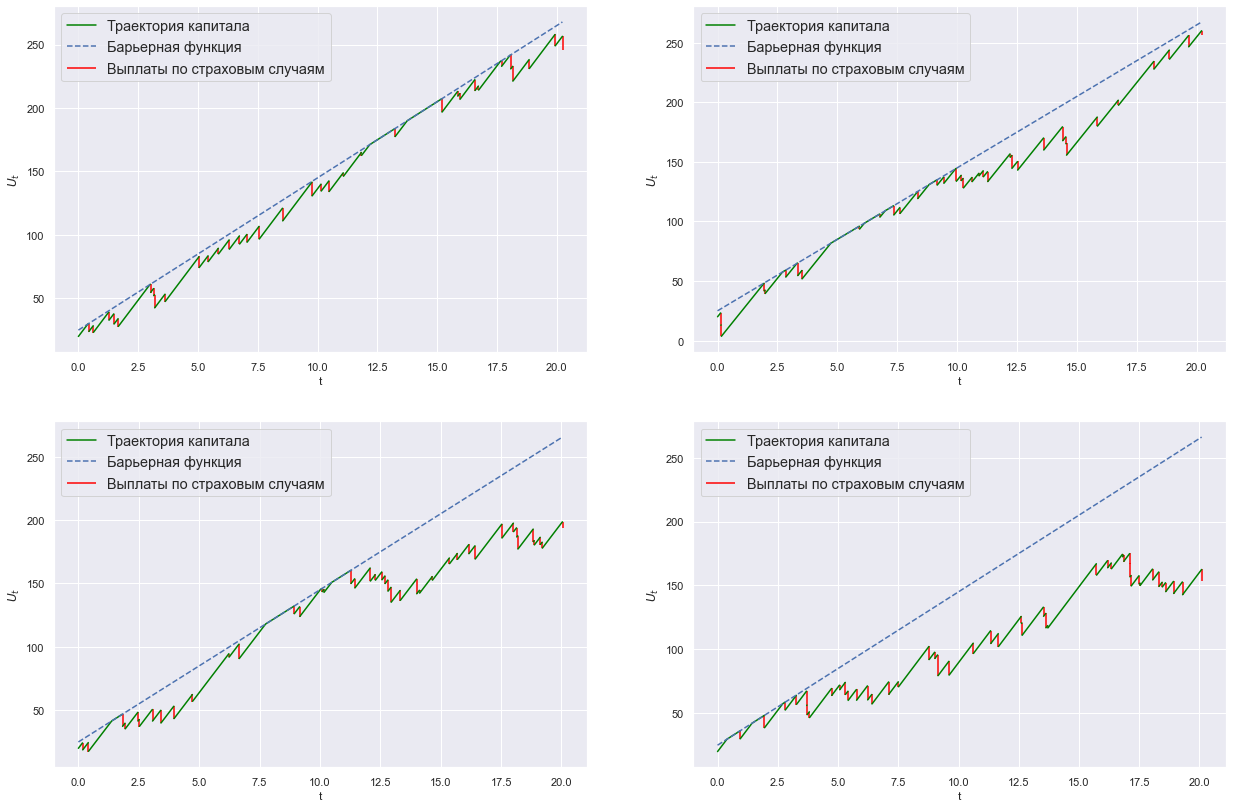

In [46]:
rows = 2
columns = 2
plt.figure(figsize=(21,14))
for i in range(1, rows * columns + 1):
    model.reset()
    real_history, payouts_bars_history = run_model(model, barrier, 20)
    barrier_history = [barrier.get_value_at(t) for t in real_history[0]]
    plt.subplot(rows, columns, i)
    plot_insurance_history(real_history, payouts_bars_history, barrier_history)
    
plt.show()

По графикам видно, что барьерная функция оказывает не большое влияние на капитал страховой компании. Скорее всего это связано с установленными параметрами модели: оценка вероятности разорения относительно большая. Соответственно, и значение капитала компании как правило будет лежать ниже барьереной функции.

Чтобы сравнить полученную оценку с результатами экспериментов применим метод Монте-Карло. Сперва для наглядности реализуем стандартную модель Крамера-Лундберга по тому же принципу:

In [47]:
class KLInsuranceModel(InsuranceModel):
    PREGENERATE_NUMBER = 100
    
    def __init__(self, start_capital, income, lambda_rate, payouts_distr):
        self.income = income
        self.exp_distr = stats.expon(scale=1 / lambda_rate)
        self.payouts_distr = payouts_distr
        self.start_capital = start_capital
        self.capital = self.start_capital
        self.t = 0
        self.__pregenerate(self.PREGENERATE_NUMBER)
        
    def __pregenerate(self, n):
        self.payouts_shifts = self.exp_distr.rvs(size=n)
        self.payouts = self.payouts_distr.rvs(size=n)
        self.cur_payout = 0
        
    def get_next_insurance_case_time(self):
        return self.t + self.payouts_shifts[self.cur_payout]
    
    def get_insurance_case_payout(self):
        return self.payouts[self.cur_payout]
    
    def update(self, t, payout):
        assert t == self.get_next_insurance_case_time() and payout == self.payouts[self.cur_payout]
        expected_capital = self.capital + self.income * (t - self.t)
        self.capital = expected_capital - payout
        self.t = t
        self.cur_payout += 1
        if self.cur_payout == len(self.payouts):
            self.__pregenerate(self.PREGENERATE_NUMBER)
    
    def get_capital(self):
        return self.capital
    
    def reset(self):
        self.capital = self.start_capital
        self.t = 0
        self.__pregenerate(self.PREGENERATE_NUMBER)

In [48]:
def plot_monte_carlo_method(default_kl_prob_est, kl_stock_prob_est, t_ends, stock_ruin_history, default_ruin_history=None):
    plt.figure(figsize=(10,7))
    plt.title('Вычисление эмпирической оценки вероятности разорения компании методом Монте-Карло')
    plt.ylim((0, kl_stock_prob_est * 1.05))
    plt.plot([t_ends[0], t_ends[-1]], [kl_stock_prob_est, kl_stock_prob_est], label='Верхняя оценка вероятности разорения акционерной страховой компании', ls='--')
    plt.plot([t_ends[0], t_ends[-1]], [default_kl_prob_est, default_kl_prob_est], label='Верхняя оценка вероятности разорения в стандартной модели Крамера-Лундберга', ls='--')
    plt.plot(t_ends, stock_ruin_history, label='Эмпирическая оценка вероятности разорения акционерной страховой компании')
    if default_ruin_history is not None:
        plt.plot(t_ends, default_ruin_history, label='Эмпирическая оценка вероятности разорения в стандартной модели Крамера-Лундберга')
    
    plt.xlabel('Временная граница эксперимента')
    plt.ylabel('Вероятность разорения')
    plt.legend()

Запустим моделирование:

In [53]:
def run_modeling(stock_model, barrier, default_model, default_kl_prob_est, kl_stock_prob_est,
                 t_min=1, t_max=500, t_step=10, samples=500):
    t_ends = []
    stock_ruin_history = []
    default_ruin_history = []
    for t_end in range(t_min, t_max + t_step, t_step):
        stock_ruin_times = 0
        default_ruin_times = 0
        t_ends.append(t_end)
        stock_ruin_history.append(0)
        default_ruin_history.append(0)
        for i in range(1, samples + 1):
            stock_model.reset()
            run_model(stock_model, barrier, t_end)
            if stock_model.get_capital() < 0:
                stock_ruin_times += 1
                stock_ruin_history[-1] = stock_ruin_times / i

            default_model.reset()
            last_t = 0
            while last_t < t_max and default_model.get_capital() >= 0:
                next_t = default_model.get_next_insurance_case_time()
                next_payout = default_model.get_insurance_case_payout()
                default_model.update(next_t, next_payout)
                last_t = next_t
                
            if default_model.get_capital() < 0:
                default_ruin_times += 1
                default_ruin_history[-1] = default_ruin_times / i

            if i % 100 == 0:
                display.clear_output(wait=True)
                plot_monte_carlo_method(default_kl_prob_est, kl_stock_prob_est, t_ends, stock_ruin_history, default_ruin_history)
                plt.show()
                
    display.clear_output(wait=True)
    plot_monte_carlo_method(default_kl_prob_est, kl_stock_prob_est, t_ends, stock_ruin_history, default_ruin_history)
    plt.show()

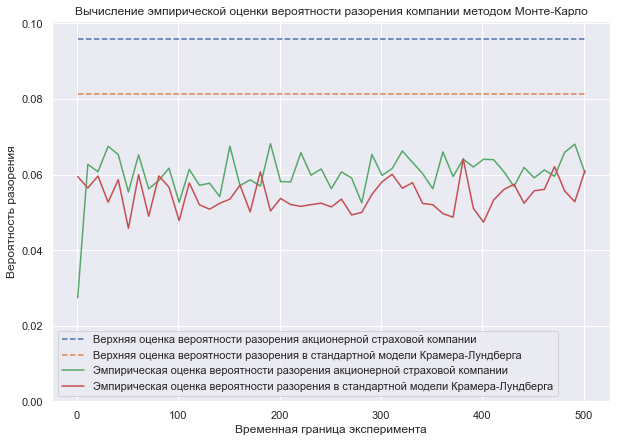

In [54]:
pois_lambda = 2
c_income = 25
x_start = 20
min_case = 2
max_case = 12
b_div_start = 25
a_div_coef = 12

cur_est_ruin_default_prob, cur_est_ruin_div_prob = calc_estimation(
    x_start,
    pois_lambda,
    c_income,
    min_case,
    max_case,
    b_div_start,
    a_div_coef
)

barrier = LinearBarrier(b_div_start, a_div_coef)
stock_model = KLStockInsuranceModel(
    x_start,
    c_income,
    pois_lambda,
    stats.uniform(loc=min_case, scale=(max_case - min_case)),
    barrier
)
default_model = KLInsuranceModel(
    x_start,
    c_income,
    pois_lambda,
    stats.uniform(loc=min_case, scale=(max_case - min_case)),
)

run_modeling(stock_model, barrier, default_model, cur_est_ruin_default_prob, cur_est_ruin_div_prob, samples=3000)

Из графиков видно, что вероятность разорения акционерной страховой компании как правило выше - это ожидаемый результат, ведь выплата дивидендов негативно влияет на размер капитала компании. Вместе с этим ни одна из эмпирических оценок не превосходит своей верхней теоретической оценки. Однако оценка вероятности разорения для модели с выплтой дивидендов кажется избыточной, ведь даже значение стандартной оценки вероятности лежит выше графика эмпирической оценки. Я связываю это с неудачным выбором параметров модели: чем менее благоприятными они являются, тем более модели с выплатой дивидендов и без выплаты дивидендов становятся друг на друга похожи. Поэтому при выборе более благоприятных параметров модели разница может быть существеннее.

Попробуем провести моделирование с другими параметрами:

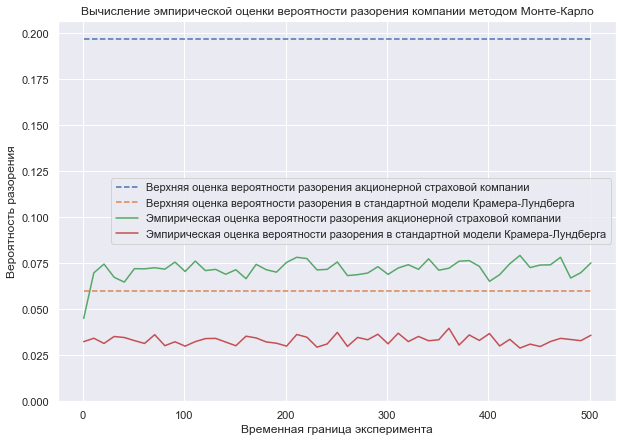

In [55]:
pois_lambda = 2
c_income = 35
x_start = 15
min_case = 2
max_case = 12
b_div_start = 18
a_div_coef = 7

cur_est_ruin_default_prob, cur_est_ruin_div_prob = calc_estimation(
    x_start,
    pois_lambda,
    c_income,
    min_case,
    max_case,
    b_div_start,
    a_div_coef
)

barrier = LinearBarrier(b_div_start, a_div_coef)
stock_model = KLStockInsuranceModel(
    x_start,
    c_income,
    pois_lambda,
    stats.uniform(loc=min_case, scale=(max_case - min_case)),
    barrier
)
default_model = KLInsuranceModel(
    x_start,
    c_income,
    pois_lambda,
    stats.uniform(loc=min_case, scale=(max_case - min_case)),
)

run_modeling(stock_model, barrier, default_model, cur_est_ruin_default_prob, cur_est_ruin_div_prob, samples=5000)

Картина существенно изменилась. Эмпирическая оценка вероятности разорения теперь лежит между двумя теоретическими оценками. Это означает, что оценка вероятности разорения стандартной модели Крамера-Лундберга для модели акционерной компании не работает, а наша полученная оценка является правильной.

В качестве эксперимента попробуем смоделировать изменение капитала акционерной страховой компании с использованием другой барьерной функции. Например, $b_t = b + a\sqrt[4]{t}$.

In [56]:
def plot_monte_carlo_stock(kl_stock_prob_est, t_ends, stock_ruin_history):
    plt.figure(figsize=(10,7))
    plt.title('Вычисление эмпирической оценки вероятности разорения акционерной страховой компании методом Монте-Карло', {'fontsize' : 'x-large'})
    plt.plot([t_ends[0], t_ends[-1]], [kl_stock_prob_est, kl_stock_prob_est], label='Верхняя оценка вероятности разорения', ls='--')
    plt.plot(t_ends, stock_ruin_history, label='Эмпирическая оценка вероятности разорения')
    plt.xlabel('Временная граница эксперимента')
    plt.ylabel('Вероятность разорения')
    plt.legend()
    

def run_stock_modeling(stock_model, barrier, kl_stock_prob_est, t_min=1, t_max=500, t_step=10, samples=3000):
    t_ends = []
    stock_ruin_history = []
    for t_end in range(t_min, t_max + t_step, t_step):
        stock_ruin_times = 0
        t_ends.append(t_end)
        stock_ruin_history.append(0)
        for i in range(1, samples + 1):
            stock_model.reset()
            run_model(stock_model, barrier, t_end)
            if stock_model.get_capital() < 0:
                stock_ruin_times += 1
                stock_ruin_history[-1] = stock_ruin_times / i

            if i % 100 == 0:
                display.clear_output(wait=True)
                plot_monte_carlo_stock(kl_stock_prob_est, t_ends, stock_ruin_history)
                plt.show()
                
    display.clear_output(wait=True)
    plot_monte_carlo_stock(kl_stock_prob_est, t_ends, stock_ruin_history)
    plt.show()

In [57]:
class PowerBarrier(Barrier):
    def __init__(self, b, a, power):
        self.b = b
        self.a = a
        self.power = power
        
    def get_value_at(self, t):
        return self.b + self.a * t ** self.power

In [58]:
pow_barrier = PowerBarrier(b_div_start, a_div_coef, 0.25)
model = KLStockInsuranceModel(
    x_start,
    c_income,
    pois_lambda,
    stats.uniform(loc=min_case, scale=(max_case - min_case)),
    pow_barrier
)

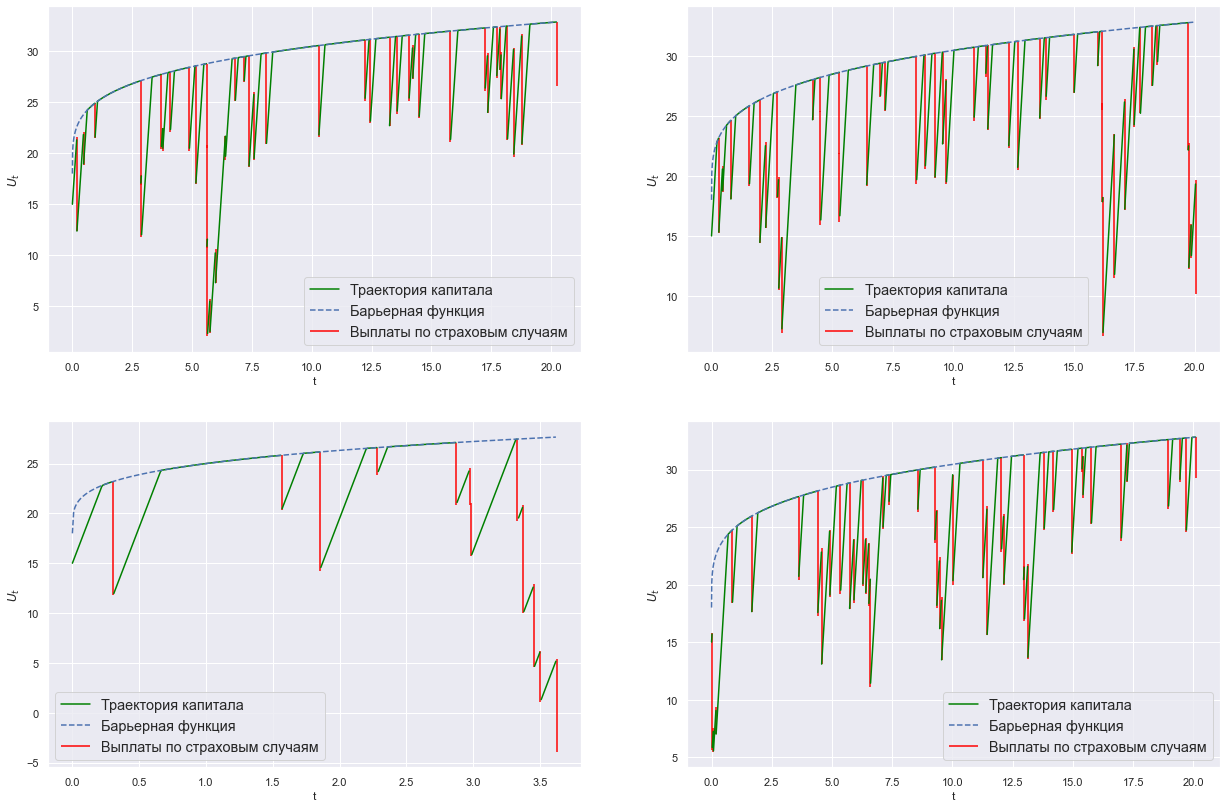

In [63]:
rows = 2
columns = 2
plt.figure(figsize=(21,14))
for i in range(1, rows * columns + 1):
    model.reset()
    real_history, payouts_bars_history = run_model(model, pow_barrier, 20)
    barrier_history = [pow_barrier.get_value_at(t) for t in real_history[0]]
    plt.subplot(rows, columns, i)
    plot_insurance_history(real_history, payouts_bars_history, barrier_history)
    
plt.show()

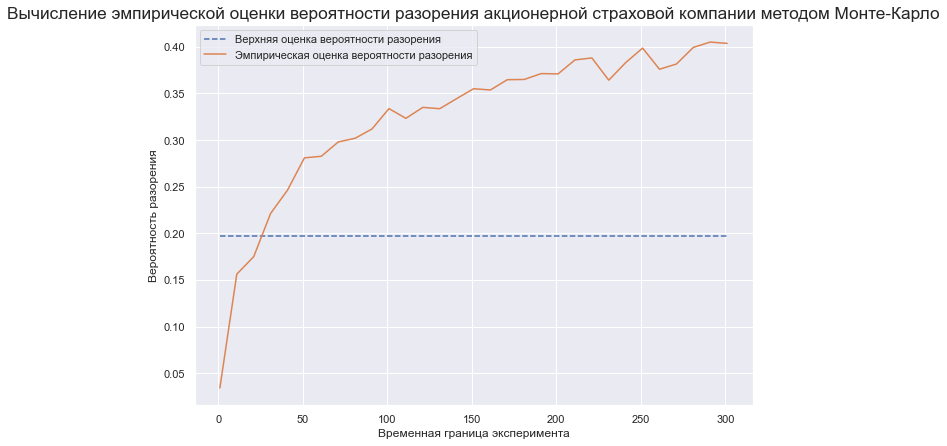

In [60]:
pow_barrier = PowerBarrier(b_div_start, a_div_coef, 0.25)
model = KLStockInsuranceModel(
    x_start,
    c_income,
    pois_lambda,
    stats.uniform(loc=min_case, scale=(max_case - min_case)),
    pow_barrier
)

cur_est_ruin_default_prob, cur_est_ruin_div_prob = calc_estimation(
    x_start,
    pois_lambda,
    c_income,
    min_case,
    max_case,
    b_div_start,
    a_div_coef
)

run_stock_modeling(model, pow_barrier, cur_est_ruin_div_prob, t_max=300, samples=3000)